/var/folders/22/ml097ncs17v22rd4q1y1vm3r0000gn/T/ipykernel_76069/4003974174.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ajcc_pathologic_stage'].fillna('Stage IA', inplace=True)


Epoch 1/50, Loss: 0.4622
Epoch 2/50, Loss: 0.1349
Epoch 3/50, Loss: 0.0732
Epoch 4/50, Loss: 0.0594
Epoch 5/50, Loss: 0.0491
Epoch 6/50, Loss: 0.0379
Epoch 7/50, Loss: 0.0356
Epoch 8/50, Loss: 0.0325
Epoch 9/50, Loss: 0.0370
Epoch 10/50, Loss: 0.0332
Epoch 11/50, Loss: 0.0300
Epoch 12/50, Loss: 0.0275
Epoch 13/50, Loss: 0.0263
Epoch 14/50, Loss: 0.0254
Epoch 15/50, Loss: 0.0203
Epoch 16/50, Loss: 0.0240
Epoch 17/50, Loss: 0.0208
Epoch 18/50, Loss: 0.0237
Epoch 19/50, Loss: 0.0158
Epoch 20/50, Loss: 0.0171
Epoch 21/50, Loss: 0.0160
Epoch 22/50, Loss: 0.0174
Epoch 23/50, Loss: 0.0138
Epoch 24/50, Loss: 0.0139
Epoch 25/50, Loss: 0.0150
Epoch 26/50, Loss: 0.0149
Epoch 27/50, Loss: 0.0137
Epoch 28/50, Loss: 0.0097
Epoch 29/50, Loss: 0.0098
Epoch 30/50, Loss: 0.0160
Epoch 31/50, Loss: 0.0113
Epoch 32/50, Loss: 0.0114
Epoch 33/50, Loss: 0.0082
Epoch 34/50, Loss: 0.0077
Epoch 35/50, Loss: 0.0060
Epoch 36/50, Loss: 0.0087
Epoch 37/50, Loss: 0.0067
Epoch 38/50, Loss: 0.0093
Epoch 39/50, Loss: 0.

/var/folders/22/ml097ncs17v22rd4q1y1vm3r0000gn/T/ipykernel_76069/4003974174.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true_class = [int(y) for y in y_true]


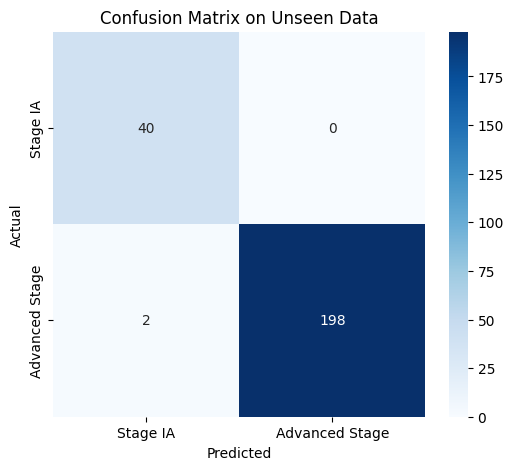

Accuracy: 0.9917
Precision: 0.9762
Recall: 0.9950
F1 Score: 0.9853
Sensitivity: 0.9900
Specificity: 1.0000


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/Users/raghav/Documents/GitHub/ACSEF/newACSEFDataframe.csv")  # Change this to your actual file path

# Handle missing values in ajcc_pathologic_stage, treating blanks as negative
df['ajcc_pathologic_stage'].fillna('Stage IA', inplace=True)

# Define cancer stage classification: Stage IA = Negative (0), all others = Positive (1)
df['cancer_stage'] = df['ajcc_pathologic_stage'].apply(lambda x: 0 if x == 'Stage IA' else 1)

# Remove highly correlated features to prevent leakage
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
correlated_features = set()
thresh = 0.9  # Correlation threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > thresh:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
df = df.drop(columns=correlated_features, errors='ignore')

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col not in ["case_id", "project_id", "icd_10_code"]:  # Exclude ID columns
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Define target and features, keeping more features for better predictions
X = df.drop(columns=["cancer_stage", "case_id", "project_id", "icd_10_code"], errors='ignore')
y = df["cancer_stage"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and unseen test set with stratification
X_train, X_unseen, y_train, y_unseen = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance dynamically
try:
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
except ValueError:
    print("SMOTE failed due to low sample size. Using Random Oversampling instead.")
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).view(-1, 1)
X_unseen_tensor = torch.tensor(X_unseen, dtype=torch.float32)
y_unseen_tensor = torch.tensor(y_unseen.values, dtype=torch.float32).view(-1, 1)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
unseen_dataset = TensorDataset(X_unseen_tensor, y_unseen_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
unseen_loader = DataLoader(unseen_dataset, batch_size=16, shuffle=False)

# Define the neural network model with dropout and weight decay
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize the model
input_size = X_train_resampled.shape[1]
model = NeuralNet(input_size)

# Define loss function and optimizer with weight decay
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate on unseen data
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in unseen_loader:
        outputs = model(inputs)
        y_true.extend(targets.numpy())
        y_pred.extend(outputs.numpy())

# Convert predictions to binary classes
y_pred_class = [1 if y > 0.5 else 0 for y in y_pred]
y_true_class = [int(y) for y in y_true]

# Compute evaluation metrics
accuracy = accuracy_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class, average='macro', zero_division=1)
recall = recall_score(y_true_class, y_pred_class, average='macro')
f1 = f1_score(y_true_class, y_pred_class, average='macro')

# Compute and display confusion matrix
conf_matrix = confusion_matrix(y_true_class, y_pred_class)

# Sensitivity (Recall) and Specificity
TP = conf_matrix[1, 1]  # True Positive
TN = conf_matrix[0, 0]  # True Negative
FP = conf_matrix[0, 1]  # False Positive
FN = conf_matrix[1, 0]  # False Negative

sensitivity = TP / (TP + FN)  # True Positive Rate
specificity = TN / (TN + FP)  # True Negative Rate

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Stage IA", "Advanced Stage"], yticklabels=["Stage IA", "Advanced Stage"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Unseen Data")
plt.show()

# Display evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


In [2]:
# Train a Random Forest model to get feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Get feature importances
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display the top 10 most important features
print("Top 10 Important Features for Confusion Matrix:")
print(feature_importances.head(10))


NameError: name 'X_train_resampled' is not defined

In [ ]:
"/Users/raghav/Documents/GitHub/ACSEF/newACSEFDataframe.csv"